In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import SimpleBuffer
from torch.autograd import grad
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

import torch
import torchsde

from functorch import vmap

from torchdiffeq import odeint

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Target Distribution

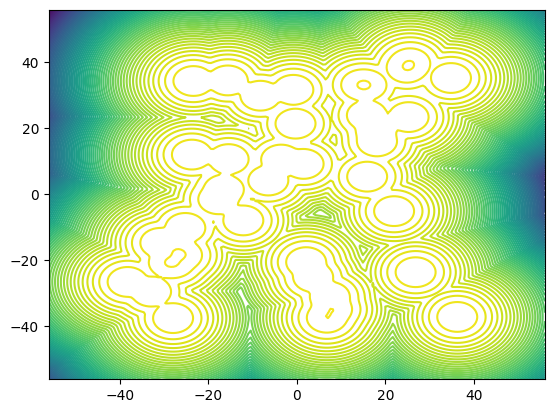

In [4]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0


if device == "cpu":
    use_gpu = False
else:
    use_gpu = True
torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=use_gpu, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to(device)

### Helper Functions

In [5]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)

   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Buffer")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
        
    target.to(device)
    plt.show()
    return [fig]

In [6]:
def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    mins = -50 #torch.min(x, dim=0)[0]
    maxs = 50 #torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    # assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

## Function Definitions

### Estimated Reward Functions

In [7]:
# calculate the log expectation of the reward
def log_E_R(_x, _t, beta, num_mc_samples, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * _t.repeat_interleave(num_mc_samples).unsqueeze(1)
    repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
    h_t  = beta * repeated_t
    h_t = h_t.unsqueeze(1)
    if var_exploding:
        # variance exploding
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    else:
        # variance preserving
        samples = repeated_x/torch.sqrt(1 - repeated_t.unsqueeze(1)) + torch.randn(repeated_x.shape).to(device) * (h_t ** 0.5)
        log_rewards = target.log_prob(unnormalize(samples, global_mins, global_maxs))
        log_expectation_R = torch.log(1 / (1 - _t)) + torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    return log_expectation_R

In [8]:
def estimated_Rt(x, t, beta, num_mc_samples=100, var_exploding=True):
    t = t * torch.ones(x.shape[0]).to(device)
    return torch.vmap(log_E_R, 
                      randomness='different', in_dims=(0,0,None,None))(x, t, beta, num_mc_samples, var_exploding=var_exploding)

In [9]:
def estimate_grad_Rt(x, t, beta, num_mc_samples=100, var_exploding=True, richardson=False):
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores_n = torch.vmap(torch.func.grad(log_E_R), 
                            in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples, 
                                                                                  var_exploding=var_exploding)
    if richardson:
        est_scores_n_div2 = torch.vmap(torch.func.grad(log_E_R), 
                                   in_dims=(0,0,None,None), randomness='different')(x, t, beta, num_mc_samples//2, 
                                                                                         var_exploding=var_exploding)
        return (2*est_scores_n - est_scores_n_div2)
    else:
        return est_scores_n

### True Reward Functions

In [10]:
def true_Rt(x, t, beta, global_mins=-50, global_maxs=50, var_exploding=True):
    h_t = beta * t
    target.convolve(h_t * (global_maxs **2), t, var_exploding=var_exploding)
    energy = target.log_prob(unnormalize(x, global_mins, global_maxs))
    target.reset()
    return energy

In [11]:
def true_grad_Rt(x, t, beta, var_exploding=True):
    samples_energy = true_Rt(x, t, beta, var_exploding=var_exploding)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores

# Testing

In [12]:
# sample uniformly from the grid
num_grid = 200
X = torch.linspace(-1, 1, num_grid)
Y = torch.linspace(-1, 1, num_grid)

# create a grid of (x,y) coordinates
x = torch.meshgrid(X, Y)

# make x into tensor
x = torch.stack(x, dim=2).reshape(-1, 2)
x = x.to(device)
x.requires_grad = True

/home/mila/t/tara.akhoundsadegh/.conda/envs/actinfenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


## VE and VP Tests

In [13]:
t = torch.rand(1, device=device)
t = t * 0  + 0.7
beta = 0.2

num_mc_samples = 200

### Log R Test

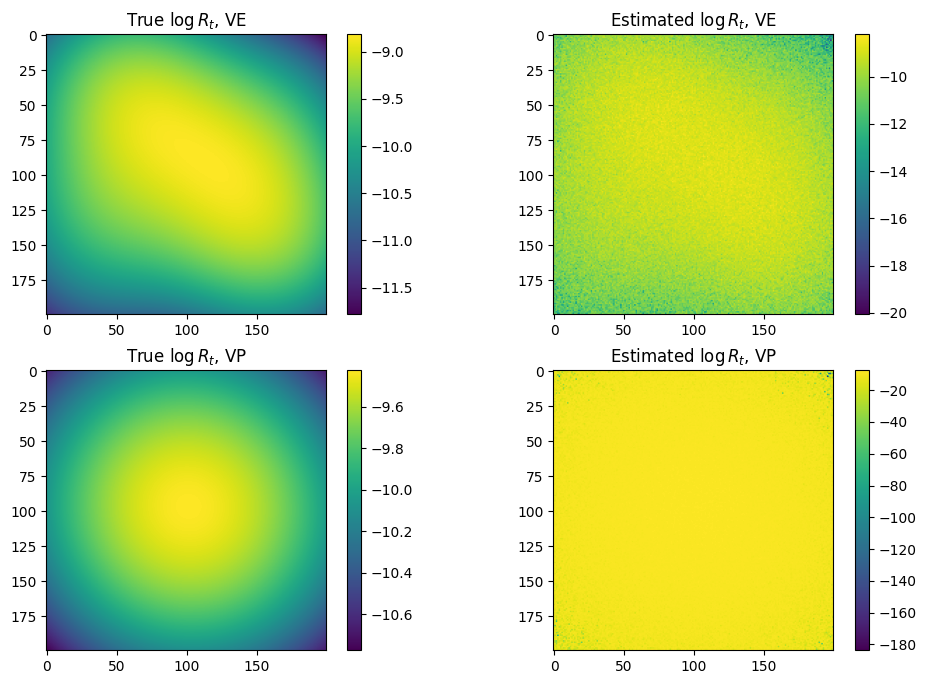

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

Rt_ve = true_Rt(x, t, beta).detach()
vmin = Rt_ve.min()
vmax = Rt_ve.max()

im = axs[0, 0].imshow(Rt_ve.reshape(num_grid, num_grid).cpu(), vmin=vmin, vmax=vmax)
# colorbar for subplot
plt.colorbar(im, ax=axs[0, 0])
axs[0, 0].set_title(r'True $\log R_t$, VE')


Rt_hat_ve = estimated_Rt(x, t, beta, num_mc_samples=num_mc_samples).detach()
im = axs[0, 1].imshow(Rt_hat_ve.reshape(num_grid, num_grid).detach().cpu())
plt.colorbar(im, ax=axs[0, 1])
axs[0, 1].set_title(r'Estimated $\log R_t$, VE')


#### VP

Rt_vp = true_Rt(x, t, 1, var_exploding=False).detach()
vmin = Rt_vp.min()
vmax = Rt_vp.max()

im = axs[1, 0].imshow(Rt_vp.reshape(num_grid, num_grid).cpu(), vmin=vmin, vmax=vmax)
# colorbar for subplot
plt.colorbar(im, ax=axs[1, 0])
axs[1, 0].set_title(r'True $\log R_t$, VP')

Rt_hat_vp = estimated_Rt(x, t, 1, num_mc_samples=num_mc_samples, var_exploding=False).detach()
im = axs[1, 1].imshow(Rt_hat_vp.reshape(num_grid, num_grid).detach().cpu())
plt.colorbar(im, ax=axs[1, 1])
axs[1, 1].set_title(r'Estimated $\log R_t$, VP')

plt.show()

# del Rt_ve, Rt_hat_ve, Rt_vp, Rt_hat_vp

### Gradient Test

In [32]:
grads_Rt = []
grads_Rt_hat = []

num_iter = 50
for i in tqdm(range(num_iter)):
    grads_Rt.append(true_grad_Rt(x, t, beta, var_exploding=True).detach())
    grads_Rt_hat.append(estimate_grad_Rt(x, t, beta, 
                                         num_mc_samples=num_mc_samples, var_exploding=True).detach())

grads_Rt = torch.stack(grads_Rt, dim=0)
grads_Rt_hat = torch.stack(grads_Rt_hat, dim=0)
grad_Rt = torch.mean(grads_Rt, dim=0).cpu()
grad_Rt_hat = torch.mean(grads_Rt_hat, dim=0).cpu()


grads_Rt = []
grads_Rt_hat = []
for i in range(num_iter):
    grads_Rt.append(true_grad_Rt(x, t, 1, var_exploding=False).detach())
    grads_Rt_hat.append(estimate_grad_Rt(x, t, 1, 
                                         num_mc_samples=num_mc_samples, var_exploding=False).detach())

grads_Rt = torch.stack(grads_Rt, dim=0)
grads_Rt_hat = torch.stack(grads_Rt_hat, dim=0)
grad_Rt_preserve = torch.mean(grads_Rt, dim=0).cpu()
grad_Rt_hat_preserve  = torch.mean(grads_Rt_hat, dim=0).cpu()

del grads_Rt_hat
del grads_Rt

100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


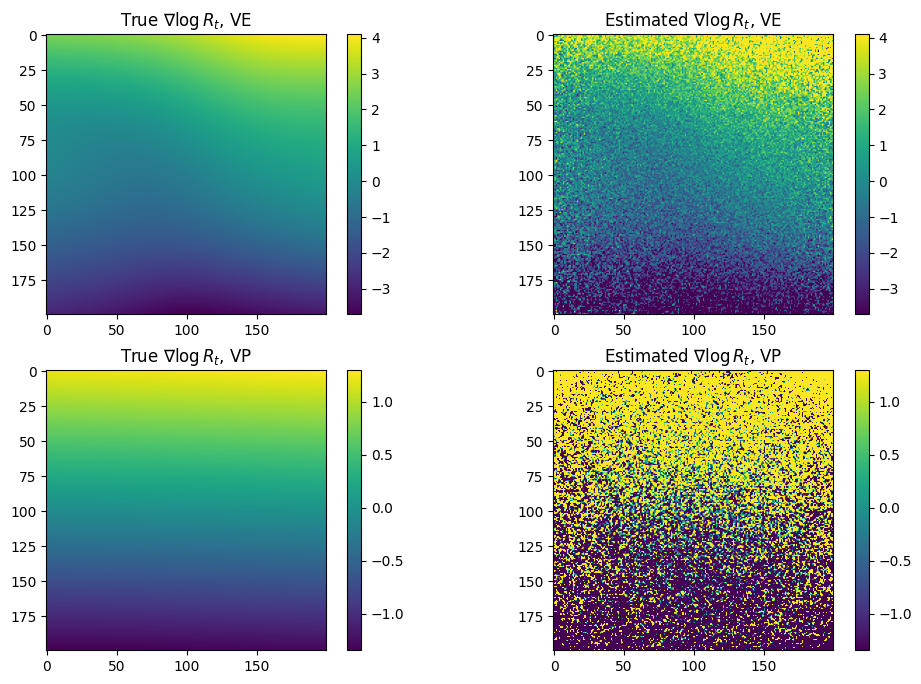

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# plot the variance exploding case
vmin = grad_Rt.min()
vmax = grad_Rt.max()

im = axs[0,0].imshow(grad_Rt.reshape(num_grid, num_grid, 2)[..., 0], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0,0])
axs[0,0].set_title(r'True $\nabla \log R_t$, VE')

im = axs[0,1].imshow(grad_Rt_hat.reshape(num_grid, num_grid, 2)[..., 0], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[0,1])
axs[0,1].set_title(r'Estimated $\nabla \log R_t$, VE')

# plot the variance preserving case
vmin = grad_Rt_preserve.min()
vmax = grad_Rt_preserve.max()

im = axs[1,0].imshow(grad_Rt_preserve.reshape(num_grid, num_grid, 2)[..., 0], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1,0])
axs[1,0].set_title(r'True $\nabla \log R_t$, VP')

im = axs[1,1].imshow(grad_Rt_hat_preserve.reshape(num_grid, num_grid, 2)[..., 0], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1,1])
axs[1,1].set_title(r'Estimated $\nabla \log R_t$, VP')

plt.show()

## Richardson Tests

In [ ]:
t = torch.rand(1, device=device)
t = t * 0  + 0.05
beta = 0.5

num_mc_samples = 100

In [ ]:
grad_Rt_per_sample = []
grad_Rt_hat_per_sample = []
richardson_grad_Rt_hat_per_sample = []

num_iter = 50
num_samples_counter = 100
for i in tqdm(range(1, num_samples_counter)):
    num_mc_samples = 5 * num_samples_counter
    for i in range(num_iter):
        grads_Rt = []
        grads_Rt_hat = []
        grads_Rt_hat_richardson = []

        grads_Rt.append(true_grad_Rt(x, t, beta).detach())
        grads_Rt_hat.append(estimate_grad_Rt(x, t, beta, 
                                            num_mc_samples=num_mc_samples).detach())
        grads_Rt_hat_richardson.append(estimate_grad_Rt(x, t, beta, 
                                            num_mc_samples=num_mc_samples, richardson=True).detach())

    grads_Rt = torch.stack(grads_Rt, dim=0)
    grads_Rt_hat = torch.stack(grads_Rt_hat, dim=0)
    grads_Rt_hat_richardson = torch.stack(grads_Rt_hat_richardson, dim=0)
    grad_Rt = torch.mean(grads_Rt, dim=0).cpu()
    grad_Rt_hat = torch.mean(grads_Rt_hat, dim=0).cpu()
    richardson_grad_Rt_hat = torch.mean(grads_Rt_hat_richardson, dim=0).cpu()

    grad_Rt_per_sample.append(grad_Rt)
    grad_Rt_hat_per_sample.append(grad_Rt_hat)
    richardson_grad_Rt_hat_per_sample.append(richardson_grad_Rt_hat)

richardson_grad_Rt_hat_per_sample = torch.stack(richardson_grad_Rt_hat_per_sample, dim=0)
grad_Rt_per_sample = torch.stack(grad_Rt_per_sample, dim=0)
grad_Rt_hat_per_sample = torch.stack(grad_Rt_hat_per_sample, dim=0)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

vmin = grad_Rt.min()
vmax = grad_Rt.max()

im = axs[0].imshow(grad_Rt.reshape(num_grid, num_grid, 2)[..., 0].cpu(), vmin=vmin, vmax=vmax)
# colorbar for subplot
plt.colorbar(im, ax=axs[0])
axs[0].set_title(r'True $\nabla \log R_t$')
#del grad_Rt
#del grads_Rt

im = axs[1].imshow(grad_Rt_hat.reshape(num_grid, num_grid, 2)[..., 0].cpu(), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[1])
axs[1].set_title(r'Estimated $\nabla \log R_t$')
#del grad_Rt_hat
#del grads_Rt_hat

im = axs[2].imshow(richardson_grad_Rt_hat.reshape(num_grid, num_grid, 2)[..., 0].cpu(), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=axs[2])
axs[2].set_title(r'Estimated Richardson $\nabla \log R_t$')
plt.show()

In [37]:
import torch
import torch.nn.functional as F

# Define the Gaussian function
def gaussian(x, sigma):
    return torch.exp(-x.pow(2) / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))

# Energy functions
class EnergyFunction(torch.nn.Module):
    def __init__(self, a, b, c):
        super().__init__()
        self._a = a
        self._b = b
        self._c = c

    def _energy_dim_1(self, x_1):
        return self._a * x_1 + self._b * x_1.pow(2) + self._c * x_1.pow(4)

    def _energy_dim_2(self, x_2):
        return 0.5 * x_2.pow(2)

    def forward(self, x):
        x_1 = x[:, 0]
        x_2 = x[:, 1]
        e1 = self._energy_dim_1(x_1)
        e2 = self._energy_dim_2(x_2)
        return e1 + e2

# Create a grid of points
grid_size = 100
x = torch.linspace(-10, 10, grid_size)
y = torch.linspace(-10, 10, grid_size)
xx, yy = torch.meshgrid(x, y)
grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# Initialize the energy function
energy_fn = EnergyFunction(a=1.0, b=-1.0, c=0.1)

# Evaluate the energy function on the grid
energy_values = energy_fn(grid)

# Apply Gaussian convolution
sigma = 1.0  # example sigma value
gaussian_kernel = gaussian(torch.arange(-3, 4, 1.0), sigma)
convolved_energy = F.conv2d(energy_values.view(1, 1, grid_size, grid_size), gaussian_kernel.view(1, 1, -1, 1))


In [38]:
convolved_energy.shape

torch.Size([1, 1, 94, 100])